In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import re
import string
import warnings
warnings.filterwarnings("ignore")
corpus=pd.read_csv(r'/drugsComTrain_raw.csv', encoding = "ISO-8859-1")
corpus.head()

,,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27.0
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,"April 27, 2010",192.0
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17.0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,03-Nov-15,10.0
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37.0


In [ ]:
corpus.columns

Index([' ', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')

In [ ]:
corpus.dtypes

                 int64
drugName        object
condition       object
review          object
rating          object
date            object
usefulCount    float64
dtype: object

In [ ]:
np.sum(corpus.isnull().any(axis=1))

924

In [ ]:
corpus.isnull().sum()

                 0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount     25
dtype: int64

In [ ]:
#dropping null values
corpus1=corpus.dropna()
np.sum(corpus1.isnull().any(axis=1))

0

In [ ]:
opinions=corpus1['review']
opinions=opinions[:5000]
corpus1=corpus1.iloc[:5000,:]

In [ ]:
#Data preprocessing
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer


def clean_text(text):
    text=text.lower()
    new_resulta = re.sub(pattern='[^a-zA-Z]',repl=' ', string=text) #remove special characters
    new_resultb = new_resulta.replace("\n", " ") #replace escape character with space 
    new_resultc = re.sub("https*\S+", " ", new_resultb) #removing urls
    new_resultd = re.sub("@\S+", " ", new_resultc) #removing mentions
    new_resulte = re.sub("#\S+", " ", new_resultd) #removing hashtags
    new_resulte= re.sub(r'(.)\1+',r'\1',new_resulte) #remove duplicates
    new_resultf = re.sub('\s{2,}', " ", new_resulte) #removing additonal white spaces
    new_resultg=re.sub(r'[^\x00-\x7F]+',' ',new_resultf) #remove encoded characters
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(new_resultg) #tokenize each review into words
    new_result2 = [word for word in word_tokens if word not in stop_words] #remove stop words
    #Stemming 
    ps = PorterStemmer()
    new_result3 = [ps.stem(word) for word in new_result2]
    lemmatizer = WordNetLemmatizer()
    new_result4 = [lemmatizer.lemmatize(word) for word in new_result3 ]
    new_result5=TreebankWordDetokenizer().detokenize([word for word in new_result4]) #detokenize to sentence after stop word removal and stemming
  
    return new_result5

def remove_emojis(text): #removing emojis from tweets
    emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF"  
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030""]+", re.UNICODE)
    return re.sub(emoji, '', text)

corpus_cleaned=[]
for i in opinions:
    j=clean_text(i)
    corpus_cleaned.append(remove_emojis(j))
len(corpus_cleaned)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


5000

In [ ]:
corpus_cleaned

['side efect take combin bystol mg fish oil',
 'son halfway fourth wek intuniv becam concern began last wek start take highest dose wil two day could hardli get bed cranki slept nearli hour drive home schol vacat unusu cale doctor monday morn said stick day se schol gete morn last two day ben problem fre much agreabl ever le emot god thing le cranki rememb al thing over behavior beter tri mani difer medic far efect',
 'use take anoth oral contracept pil cycl hapi light period max day side efect contain hormon gestoden avail u switch lybrel ingredi similar pil end start lybrel imedi first day period instruct said period last two wek take second pack two wek third pack thing got even wors third period last two wek end third wek stil daili brown discharg posit side side efect idea period fre tempt ala',
 'first time use form birth control glad went patch ben month first decreas libido subsid downsid made period longer day exact use period day max also made cramp intens first two day perio

## **Representing words using vectors: Word Embedding**
### Using Bag of Words to give a dense representation instead of one hot encoding which is not feasible for such a large number of words.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer() 
corpus2 = cv.fit_transform(corpus_cleaned)
bow = pd.DataFrame(corpus2.todense()) #shape is (5000, 8105)- rows indicate each review and columns indicate terms
bow.columns = cv.get_feature_names() #words/terms
bow_matrix = bow.T #rows will be all the unique terms
bow_matrix.columns = ['Review '+str(i) for i in range(1, bow.shape[0]+1)] #columns will be the documents/reviews 
print(bow_matrix.head(50))

               Review 1  Review 2  Review 3  Review 4  Review 5  Review 6  \
ab                    0         0         0         0         0         0   
abad                  0         0         0         0         0         0   
abal                  0         0         0         0         0         0   
abat                  0         0         0         0         0         0   
abc                   0         0         0         0         0         0   
abces                 0         0         0         0         0         0   
abd                   0         0         0         0         0         0   
abdomen               0         0         0         0         0         0   
abdomin               0         0         0         0         0         0   
abil                  0         0         0         0         0         0   
abilifi               0         0         0         0         0         0   
abl                   0         0         0         0         0         0   

In [ ]:
column_sum=bow_matrix.sum(axis=1)
column_sum.sort_values()  #occurence of each word in the documents

lightend         1
lumpectomi       1
lunchbox         1
lunchtim         1
lusciou          1
              ... 
year          2044
month         2075
ben           2405
take          2974
day           3037
Length: 8105, dtype: int64

In [ ]:
row_sum=bow_matrix.sum(axis=0)
row_sum.sort_values()  # words in each document/review

Review 1903      1
Review 3272      1
Review 4322      1
Review 982       1
Review 2650      1
              ... 
Review 1633    120
Review 2331    129
Review 4810    161
Review 1610    166
Review 55      186
Length: 5000, dtype: int64

In [ ]:
#TF/IDF
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer=TfidfTransformer(smooth_idf=True) #creating instance; setting smooth idf as True to prevent division by zero
tfidf_transformer.fit(corpus2) #fitting on term document matrix
tf_idf2=tfidf_transformer.transform(corpus2)
feature_names = cv.get_feature_names()
tf_idf3=tf_idf2.todense()
df_tf_idf= pd.DataFrame(tf_idf2.T.todense(), index=feature_names) #index/rows represent unique words
df_tf_idf.columns = ['Review '+str(i) for i in range(1, corpus2.shape[0]+1)] #columns will be the reviews or documents
df_tf_idf #importance of each word in the documents

,Review 1,Review 2,Review 3,Review 4,Review 5,Review 6,Review 7,Review 8,Review 9,Review 10,...,Review 4991,Review 4992,Review 4993,Review 4994,Review 4995,Review 4996,Review 4997,Review 4998,Review 4999,Review 5000
ab,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abad,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abat,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abc,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zydi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zydu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zyprexa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zyrtec,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
col_sum1=df_tf_idf.sum(axis=1)
col_sum1.sort_values() #tf/idf for each term

difuctli      0.100807
flactuat      0.100807
virtu         0.103872
freqent       0.103872
enlong        0.103872
               ...    
month       142.208067
ben         153.066827
work        158.946037
take        177.921730
day         179.525255
Length: 8105, dtype: float64

In [ ]:
# from tensorflow.keras.preprocessing import sequence
# tokenizer=keras.preprocessing.text.Tokenizer() 
# tokenizer.fit_on_texts(corpus1.review) #maps each word to unique id
# sequences = tokenizer.texts_to_sequences(corpus1.review)
# sequences_matrix = sequence.pad_sequences(sequences,maxlen=500)
# sequences_matrix
#tokenizer.sequences_to_matrix(sequences, mode='binary' )

In [ ]:
categories=[]
corpus1.rating=corpus1.rating.astype(int)
for i in corpus1.rating:
  if i <=2:
    categories.append(1)#"Ineffective"
  elif (i >2) & (i<=4):
    categories.append(2)#"Slightly effective"
  elif (i >4) & (i<=6):
    categories.append(3)#"Moderately effective"
  elif (i >6) & (i<=8):
    categories.append(4)#"Considerably effective"
  elif (i>8):
    categories.append(5)#"Highly effective"
corpus1['effectiveness']=categories
corpus1.head()

,,drugName,condition,review,rating,date,usefulCount,effectiveness
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27.0,5
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,"April 27, 2010",192.0,4
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17.0,3
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,03-Nov-15,10.0,4
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37.0,5


In [ ]:
np.unique(corpus1['effectiveness']) #5 classes

array([1, 2, 3, 4, 5])

In [ ]:
#Train-validation-test split
X=tf_idf3
y=corpus1.effectiveness
from sklearn.model_selection import train_test_split
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=43, stratify=y)
#USing validation data since we will be tuning hyperparameters
X_train,X_valid=X_train_full[:3600],X_train_full[3600:]
y_train, y_valid = y_train_full[:3600], y_train_full[3600:]

In [ ]:
#One hot encoding for target variable
from keras.utils.np_utils import to_categorical
Y_train = to_categorical(y_train)
Y_train=Y_train[:,1:6]
Y_test=to_categorical(y_test)
Y_test=Y_test[:,1:6]
Y_valid=to_categorical(y_valid)
Y_valid=Y_valid[:,1:6]

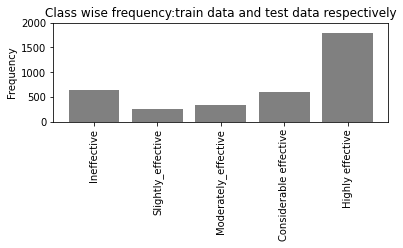

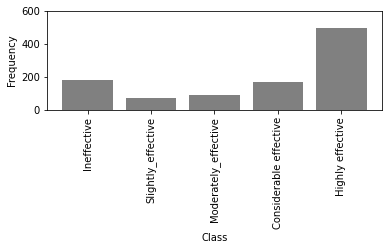

In [ ]:
import matplotlib.pyplot as plt
class1, freq1 = np.unique(y_train, return_counts=True) #unique classes in data and their corresponding frequency
class2, freq2 = np.unique(y_test, return_counts=True)
plt.subplot(2,1,1)
plt.bar(class1,freq1,color="grey")
plt.title("Class wise frequency:train data and test data respectively")
plt.ylabel("Frequency")
plt.ylim(0,2000)
xlabels=['Ineffective','Slightly_effective','Moderately_effective','Considerable effective','Highly effective']
plt.xticks(ticks = range(1,6),labels=xlabels, color='black', rotation=90, fontsize='10')
plt.show()
plt.subplot(2,1,2)
plt.bar(class2,freq2,color="grey")
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.ylim(0,600)
plt.xticks(ticks = range(1,6),labels=xlabels, color='black', rotation=90, fontsize='10')
plt.show()

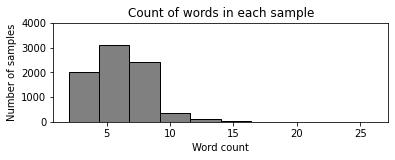

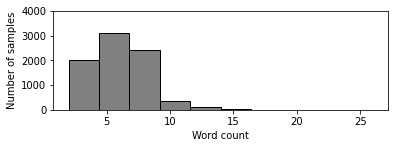

In [ ]:
X2=bow
y2=corpus1.effectiveness

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=43)

count=[] 
count2=[]
for i in X_train2:
     count.append(len(i))
for i in X_test2:
     count2.append(len(i))
plt.subplot(2,1,1)
plt.hist(count,color="grey", edgecolor='black')
plt.title("Count of words in train and test sets")
plt.xlabel("Word count")
plt.ylabel("Number of samples")
plt.ylim(0,4000)
plt.show()

plt.subplot(2,1,1)
plt.hist(count2,color="grey", edgecolor='black')
plt.xlabel("Word count")
plt.ylabel("Number of samples")
plt.ylim(0,4000)
plt.show()

#Most words occurd 4 to 7 times in the train and test data.

In [ ]:
#LSA for the purpose of visualizations
from sklearn.decomposition import TruncatedSVD
num_components=10 #10 topics 
lsa = TruncatedSVD(n_components=num_components, n_iter=100, random_state=43) #this will give 3 matrices (term-topic matrix,topic-topic matrix and topic-document matrix)
lsa.fit_transform(tf_idf3) #fitting on data
sigma = lsa.singular_values_ #for each topic
V_transpose = lsa.components_.T #term-topic matrix
terms = cv.get_feature_names() #unique terms
topics=['time','menstruation','pain','side effects','anxiety','birth control','pills','weight gain','insomnia','dose']
for index, component in enumerate(lsa.components_):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10] #printing top 10 words associated with each of the 10 topics
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index)+": ",top_terms_list)

Topic 0:  ['day', 'take', 'ben', 'month', 'work', 'efect', 'wek', 'year', 'pain', 'period']
Topic 1:  ['period', 'birth', 'month', 'control', 'pil', 'cramp', 'gain', 'weight', 'blede', 'acn']
Topic 2:  ['pain', 'cramp', 'day', 'insert', 'back', 'hour', 'relief', 'period', 'got', 'blede']
Topic 3:  ['work', 'efect', 'side', 'great', 'wel', 'pain', 'use', 'medicin', 'birth', 'control']
Topic 4:  ['pain', 'help', 'year', 'life', 'gain', 'ben', 'weight', 'depres', 'control', 'anxieti']
Topic 5:  ['efect', 'side', 'pain', 'day', 'headach', 'wek', 'nausea', 'weight', 'lb', 'experienc']
Topic 6:  ['period', 'anxieti', 'mg', 'work', 'panic', 'control', 'depres', 'pil', 'atack', 'birth']
Topic 7:  ['weight', 'lb', 'gain', 'work', 'lost', 'pound', 'eat', 'pain', 'lose', 'wek']
Topic 8:  ['pil', 'help', 'take', 'slep', 'control', 'birth', 'night', 'hour', 'medicin', 'make']
Topic 9:  ['mg', 'take', 'control', 'birth', 'ben', 'pil', 'acn', 'night', 'year', 'month']


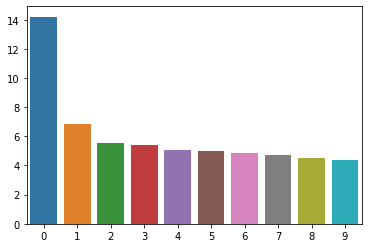

In [ ]:
import seaborn as sns
sns.barplot(x=list(range(len(sigma))), y = sigma) #how much each component/topic explains the variance in the data
#Topic 1 explains highest variance in data

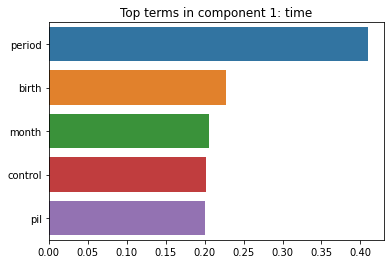

In [ ]:
import matplotlib.pyplot as plt
term_topic=pd.DataFrame(V_transpose,index=cv.get_feature_names()) #converting term-document matrix into dataframe; rows are the unique terms
term_topic.columns=['Topic '+str(i) for i in range(0, 10)] #10 topics
topic1 = term_topic['Topic 1']
topic1 = topic1.sort_values(ascending=False)
top_5 = topic1[:5]
plt.title('Top terms in component 1: time') #Top 5 terms in document 1 based on term-document matrix
sns.barplot(x= top_5.values, y=top_5.index)

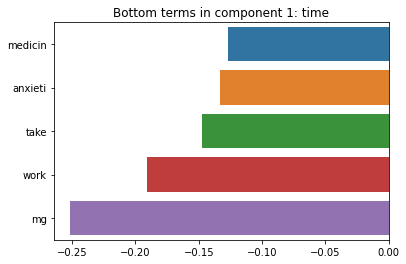

In [ ]:
bottom_5 = topic1[-5:]
plt.title('Bottom terms in component 1: time')
sns.barplot(x= bottom_5.values, y=bottom_5.index)#Bottom 5 terms in document 1 based on term-document matrix

In [ ]:
#LDA
import gensim
from gensim import corpora, models
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
corpus4=[]
for i in corpus1: #tokenizing preprocessed data
    corpus4.append(tokenizer.tokenize(i))
    
dictionary = corpora.Dictionary(corpus4) #dictonary for our tokenized data
corpus5 = [dictionary.doc2bow(i) for i in corpus4] #word id and frequency

ldamodel = gensim.models.ldamodel.LdaModel(corpus5, num_topics=10, id2word = dictionary, passes=100,random_state=42)
print(ldamodel.print_topics())

[(0, '0.407*"drugName" + 0.407*"date" + 0.037*"condition" + 0.037*"review" + 0.037*"rating" + 0.037*"usefulCount" + 0.037*"effectiveness"'), (1, '0.407*"condition" + 0.407*"usefulCount" + 0.037*"drugName" + 0.037*"review" + 0.037*"rating" + 0.037*"date" + 0.037*"effectiveness"'), (2, '0.143*"drugName" + 0.143*"condition" + 0.143*"date" + 0.143*"usefulCount" + 0.143*"review" + 0.143*"rating" + 0.143*"effectiveness"'), (3, '0.143*"drugName" + 0.143*"condition" + 0.143*"date" + 0.143*"usefulCount" + 0.143*"review" + 0.143*"rating" + 0.143*"effectiveness"'), (4, '0.143*"drugName" + 0.143*"condition" + 0.143*"date" + 0.143*"usefulCount" + 0.143*"review" + 0.143*"rating" + 0.143*"effectiveness"'), (5, '0.143*"drugName" + 0.143*"condition" + 0.143*"date" + 0.143*"usefulCount" + 0.143*"review" + 0.143*"rating" + 0.143*"effectiveness"'), (6, '0.647*"rating" + 0.059*"drugName" + 0.059*"condition" + 0.059*"review" + 0.059*"date" + 0.059*"usefulCount" + 0.059*"effectiveness"'), (7, '0.143*"drugNam

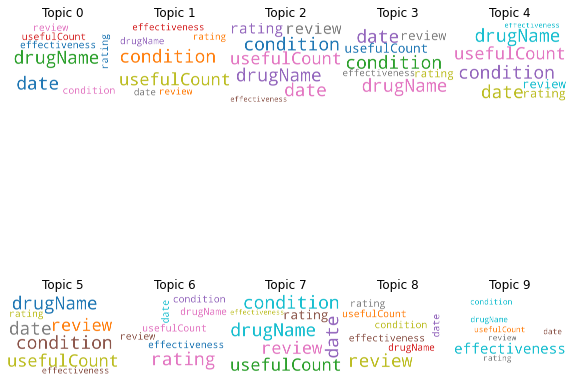

In [ ]:
#Visualizing lda results using word cloud 
from wordcloud import WordCloud

cloud = WordCloud(background_color='white',width=2500,height=1800,colormap='tab10') #word cloud specifications
topics_lda = ldamodel.show_topics(formatted=False) #all topics, formatted=False gives only words and their weightage
fig, axes = plt.subplots(2,5, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    keyword_freq = dict(topics_lda[i][1]) #keyword frequencies under each topic
    cloud.generate_from_frequencies(keyword_freq, max_font_size=400) #creating word cloud from the computed frequencies
    plt.imshow(cloud)
    ax.set_title('Topic ' + str(i))
    plt.axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off') #no box around word cloud
plt.show()

### **MLP-** **1 hidden layer**


In [ ]:
#Simple MLP with 1 hidden layer
#Relu activation function in hidden layer
#Softmax activation in output layer
#Adam optimizer
#Early stopping, checkpoint callbacks

#Step 1:Build model
model=keras.models.Sequential() 
model.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,])) 
model.add(keras.layers.Dense(5,activation="softmax")) #5 output classes

In [ ]:
model.summary() #name of each layer, its shape and number of parameters

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               810600    
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 811,105
Trainable params: 811,105
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.layers #layers in the model 

In [ ]:
hidden=model.layers[1] #layer 1 (dense layer)
weight,bias=hidden.get_weights()
weight #connection weights at hidden layer1

array([[ 0.13145964, -0.10310251,  0.06780918, -0.03825469,  0.12361713],
       [ 0.11778064, -0.09830023,  0.0567167 ,  0.05300258,  0.04366116],
       [-0.19693905, -0.22888052, -0.10319261, -0.23102915, -0.00689091],
       [-0.0459998 ,  0.07510604,  0.13189666,  0.01902743,  0.17959432],
       [ 0.00748619,  0.00082219,  0.23303233,  0.05072834,  0.20880316],
       [ 0.1654699 ,  0.02829506, -0.02234814,  0.2254097 ,  0.1554446 ],
       [-0.22968583,  0.0718299 , -0.09345053, -0.03871343,  0.09005021],
       [-0.01389305,  0.19133247,  0.23226021, -0.04367147,  0.13898818],
       [-0.1544353 ,  0.13533224, -0.02887969,  0.06000198, -0.20677552],
       [ 0.0128506 ,  0.05116685,  0.23561727, -0.03163542,  0.10928704],
       [ 0.18179046,  0.05510698,  0.07242246,  0.10594009,  0.19305162],
       [-0.00892362,  0.11490251,  0.14091612,  0.02122252,  0.03909014],
       [-0.22030547, -0.17341562,  0.14421277, -0.21067184, -0.17529878],
       [ 0.1252261 , -0.11376481, -0.2

In [ ]:
checkpoint_callback=keras.callbacks.ModelCheckpoint('model.h5') #save at end of every epoch
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True) #early stopping used to stop training when there is no improvement on validation set for 5 epochs

#Step 2: Compile model
from keras import optimizers
model.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"]) #using categorical crossentropy since data is one hot encoded

In [ ]:
#Step 3: Fit model on training data
history=model.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback,early_stopping_cb]) #train and validation loss, accuracy

Epoch 1/10
225/225 [==============================] - 2s 8ms/step - loss: 1.3430 - accuracy: 0.4939 - val_loss: 1.1893 - val_accuracy: 0.5425
Epoch 2/10
225/225 [==============================] - 1s 5ms/step - loss: 1.0513 - accuracy: 0.5911 - val_loss: 1.0540 - val_accuracy: 0.6112
Epoch 3/10
225/225 [==============================] - 1s 6ms/step - loss: 0.8048 - accuracy: 0.7069 - val_loss: 1.0489 - val_accuracy: 0.6075
Epoch 4/10
225/225 [==============================] - 1s 6ms/step - loss: 0.5953 - accuracy: 0.8140 - val_loss: 1.0979 - val_accuracy: 0.6050
Epoch 5/10
225/225 [==============================] - 1s 6ms/step - loss: 0.4329 - accuracy: 0.8828 - val_loss: 1.1653 - val_accuracy: 0.5950
Epoch 6/10
225/225 [==============================] - 1s 6ms/step - loss: 0.3130 - accuracy: 0.9257 - val_loss: 1.2608 - val_accuracy: 0.5738
Epoch 7/10
225/225 [==============================] - 1s 6ms/step - loss: 0.2275 - accuracy: 0.9503 - val_loss: 1.3565 - val_accuracy: 0.5775
Epoch 

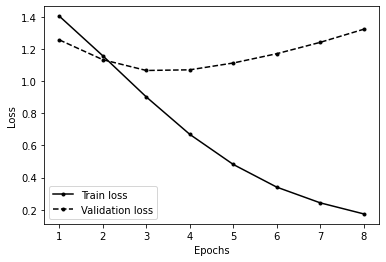

In [ ]:
#Learning curve
def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    epoch = range(1, 8 + 1)

    plt.plot(epoch, metric, color="black",marker='.', label='Train ' + metric_name)
    plt.plot(epoch, val_metric, color="black",marker='.', linestyle='dashed',label='Validation ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
eval_metric(history,'loss')
# pd.DataFrame(history.history).plot(figsize=(5,5))#train and validation loss and accuracy across all epochs
# plt.title("Learning curve")
# plt.xlabel("Epochs")
# plt.ylabel("Loss and acuracy")

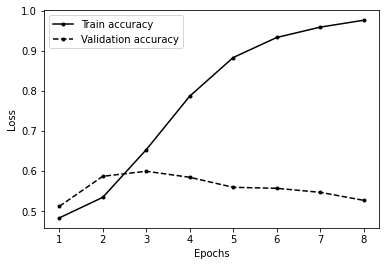

In [ ]:
eval_metric(history,'accuracy')

In [ ]:
#Step 5: evaluating model 
model.evaluate(X_test,Y_test) #accuracy on test set is 52.10%

63/63 [==============================] - 0s 3ms/step - loss: 1.1878 - accuracy: 0.5280


[1.1878052949905396, 0.527999997138977]

### **MLP- 1 hidden layer without Early stopping**

In [ ]:
modela=keras.models.Sequential() 
modela.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,])) 
modela.add(keras.layers.Dense(5,activation="softmax")) #5 output classes

modela.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])
historya=modela.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),verbose=0)
modela.evaluate(X_test,Y_test) #accuracy on test set is 51.90%

63/63 [==============================] - 0s 3ms/step - loss: 1.9688 - accuracy: 0.4895


[1.9688386917114258, 0.4894999861717224]

### **MLP-** **2 hidden** **layers** 

In [ ]:
model2=keras.models.Sequential() 
model2.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,])) 
model2.add(keras.layers.Dense(100,activation="relu")) 
model2.add(keras.layers.Dense(5,activation="softmax"))

model2.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])

checkpoint_callback2=keras.callbacks.ModelCheckpoint('model2.h5') #save at end of every epoch
history2=model2.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback2,early_stopping_cb])

Epoch 1/10
113/113 [==============================] - 2s 13ms/step - loss: 1.3688 - accuracy: 0.4867 - val_loss: 1.2143 - val_accuracy: 0.5525
Epoch 2/10
113/113 [==============================] - 1s 6ms/step - loss: 0.9963 - accuracy: 0.6108 - val_loss: 1.0758 - val_accuracy: 0.5950
Epoch 3/10
113/113 [==============================] - 0s 4ms/step - loss: 0.6117 - accuracy: 0.7847 - val_loss: 1.2514 - val_accuracy: 0.5650
Epoch 4/10
113/113 [==============================] - 1s 4ms/step - loss: 0.2970 - accuracy: 0.9267 - val_loss: 1.4829 - val_accuracy: 0.5225
Epoch 5/10
113/113 [==============================] - 0s 4ms/step - loss: 0.1080 - accuracy: 0.9806 - val_loss: 1.7798 - val_accuracy: 0.5000
Epoch 6/10
113/113 [==============================] - 0s 4ms/step - loss: 0.0394 - accuracy: 0.9967 - val_loss: 2.0027 - val_accuracy: 0.5175
Epoch 7/10
113/113 [==============================] - 0s 4ms/step - loss: 0.0175 - accuracy: 0.9986 - val_loss: 2.1593 - val_accuracy: 0.5150


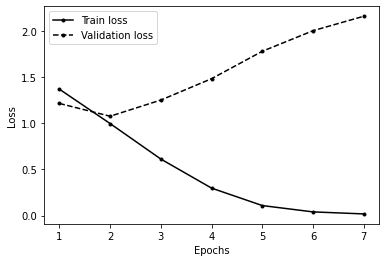

In [ ]:
#Learning curve
# pd.DataFrame(history2.history).plot(figsize=(5,5))#train and validation loss and accuracy across all epochs
# plt.title("Learning curve")
# plt.xlabel("Epochs")
# plt.ylabel("Loss and acuracy")
def eval_metric2(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    epoch = range(1, 7 + 1)

    plt.plot(epoch, metric, color="black",marker='.', label='Train ' + metric_name)
    plt.plot(epoch, val_metric, color="black",marker='.', linestyle='dashed',label='Validation ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
eval_metric2(history2,'loss')

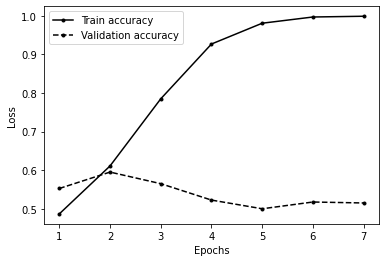

In [ ]:
eval_metric2(history2,'accuracy')

In [ ]:
model2.evaluate(X_test,Y_test) #accuracy on test set is 54.40%

32/32 [==============================] - 0s 3ms/step - loss: 1.1876 - accuracy: 0.5400


[1.1876261234283447, 0.5400000214576721]

### **MLP- 2 hidden layers without Early stopping**

In [ ]:
model2a=keras.models.Sequential() 
model2a.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,])) 
model2a.add(keras.layers.Dense(100,activation="relu"))
model2a.add(keras.layers.Dense(5,activation="softmax")) #5 output classes

model2a.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])
history2a=model2a.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),verbose=0)
model2a.evaluate(X_test,Y_test) #accuracy on test set is 49.5%

32/32 [==============================] - 0s 3ms/step - loss: 2.6396 - accuracy: 0.5030


[2.6396234035491943, 0.503000020980835]

### **MLP-** **3 hidden layers**

In [ ]:
model3=keras.models.Sequential() 
model3.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,])) 
model3.add(keras.layers.Dense(100,activation="relu")) 
model3.add(keras.layers.Dense(100,activation="relu")) 
model3.add(keras.layers.Dense(5,activation="softmax"))

model3.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])

checkpoint_callback3=keras.callbacks.ModelCheckpoint('model3.h5') #save at end of every epoch
history3=model3.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback3,early_stopping_cb])

Epoch 1/10
113/113 [==============================] - 1s 5ms/step - loss: 1.3589 - accuracy: 0.4844 - val_loss: 1.1941 - val_accuracy: 0.5200
Epoch 2/10
113/113 [==============================] - 0s 4ms/step - loss: 0.9764 - accuracy: 0.6150 - val_loss: 1.1014 - val_accuracy: 0.5875
Epoch 3/10
113/113 [==============================] - 0s 4ms/step - loss: 0.5661 - accuracy: 0.7911 - val_loss: 1.4024 - val_accuracy: 0.5325
Epoch 4/10
113/113 [==============================] - 1s 4ms/step - loss: 0.2492 - accuracy: 0.9306 - val_loss: 1.9005 - val_accuracy: 0.5300
Epoch 5/10
113/113 [==============================] - 0s 4ms/step - loss: 0.0813 - accuracy: 0.9825 - val_loss: 2.3004 - val_accuracy: 0.4975
Epoch 6/10
113/113 [==============================] - 0s 4ms/step - loss: 0.0247 - accuracy: 0.9958 - val_loss: 2.6239 - val_accuracy: 0.5300
Epoch 7/10
113/113 [==============================] - 0s 4ms/step - loss: 0.0095 - accuracy: 0.9986 - val_loss: 2.8430 - val_accuracy: 0.5075


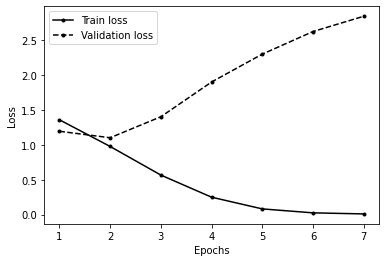

In [ ]:
#Learning curve
# pd.DataFrame(history3.history).plot(figsize=(5,5))#train and validation loss and accuracy across all epochs
# plt.title("Learning curve")
# plt.xlabel("Epochs")
# plt.ylabel("Loss and acuracy")
eval_metric2(history3,'loss')

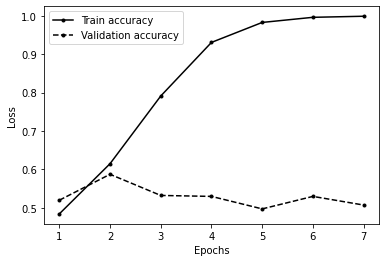

In [ ]:
eval_metric2(history3,'accuracy')

In [ ]:
model3.evaluate(X_test,Y_test) #accuracy on test set is 54.10%

32/32 [==============================] - 0s 3ms/step - loss: 1.2790 - accuracy: 0.4910


[1.2789980173110962, 0.4909999966621399]

### **MLP- 3 hidden layers without Early stopping**


In [ ]:
model3a=keras.models.Sequential() 
model3a.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,])) 
model3a.add(keras.layers.Dense(100,activation="relu")) 
model3a.add(keras.layers.Dense(100,activation="relu")) 
model3a.add(keras.layers.Dense(5,activation="softmax"))

model3a.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])

history3a=model3a.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),verbose=0)
model3a.evaluate(X_test,Y_test) #49.30%

32/32 [==============================] - 0s 3ms/step - loss: 3.7317 - accuracy: 0.4890


[3.7316577434539795, 0.48899999260902405]

### **MLP-** **4 hidden layers**


In [ ]:
model3b=keras.models.Sequential() 
model3b.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,])) 
model3b.add(keras.layers.Dense(100,activation="relu")) 
model3b.add(keras.layers.Dense(100,activation="relu")) 
model3b.add(keras.layers.Dense(100,activation="relu")) 
model3b.add(keras.layers.Dense(5,activation="softmax"))

model3b.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])

checkpoint_callback3b=keras.callbacks.ModelCheckpoint('model3b.h5') #save at end of every epoch
history3b=model3b.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback3b,early_stopping_cb])

Epoch 1/10
113/113 [==============================] - 1s 5ms/step - loss: 1.3477 - accuracy: 0.4861 - val_loss: 1.2003 - val_accuracy: 0.5475
Epoch 2/10
113/113 [==============================] - 0s 4ms/step - loss: 1.0213 - accuracy: 0.6072 - val_loss: 1.1721 - val_accuracy: 0.5825
Epoch 3/10
113/113 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.7206 - val_loss: 1.3579 - val_accuracy: 0.5675
Epoch 4/10
113/113 [==============================] - 0s 4ms/step - loss: 0.3482 - accuracy: 0.8686 - val_loss: 1.8213 - val_accuracy: 0.5000
Epoch 5/10
113/113 [==============================] - 1s 4ms/step - loss: 0.1412 - accuracy: 0.9550 - val_loss: 2.5209 - val_accuracy: 0.5025
Epoch 6/10
113/113 [==============================] - 0s 4ms/step - loss: 0.0499 - accuracy: 0.9864 - val_loss: 2.9802 - val_accuracy: 0.5000
Epoch 7/10
113/113 [==============================] - 1s 5ms/step - loss: 0.0144 - accuracy: 0.9978 - val_loss: 3.3083 - val_accuracy: 0.5250


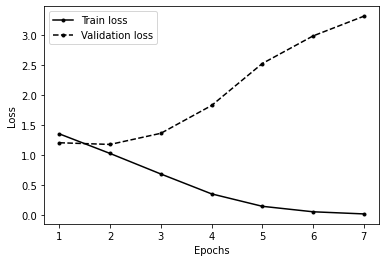

In [ ]:
#Learning curve
# pd.DataFrame(history3b.history).plot(figsize=(5,5))#train and validation loss and accuracy across all epochs
# plt.title("Learning curve")
# plt.xlabel("Epochs")
# plt.ylabel("Loss and acuracy")
eval_metric2(history3b,'loss')

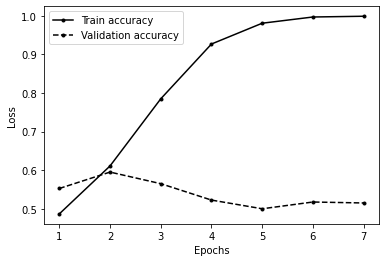

In [ ]:
eval_metric2(history2,'accuracy')

In [ ]:
model3b.evaluate(X_test,Y_test) #accuracy on test set is 52.30%

32/32 [==============================] - 0s 3ms/step - loss: 1.2552 - accuracy: 0.5330


[1.2552311420440674, 0.5329999923706055]

### **MLP- 4 hidden layers without Early stopping**

In [ ]:
model3ba=keras.models.Sequential() 
model3ba.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,])) 
model3ba.add(keras.layers.Dense(100,activation="relu")) 
model3ba.add(keras.layers.Dense(100,activation="relu")) 
model3ba.add(keras.layers.Dense(100,activation="relu")) 
model3ba.add(keras.layers.Dense(5,activation="softmax"))

model3ba.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])

history3ba=model3ba.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),verbose=0)
model3ba.evaluate(X_test,Y_test) #45.70%

32/32 [==============================] - 0s 3ms/step - loss: 5.3042 - accuracy: 0.4820


[5.304185390472412, 0.4819999933242798]

In [ ]:
#Highest accuracy for 2 and 3 hidden layer MLPs.
#In general, accuracy of test data is higher when early stopping is used as it helps minimize overfitting.

In [ ]:
#making predictions using for first 10 test reviews (2 hidden layer MLP with early stopping)- gave best accuracy so far
prob=model2.predict(X_test[:10]) #probability per class
labels=np.argmax(prob,axis=1)
labels #predicted class labels
np.array(xlabels)[labels] #predicted classes 

array(['Considerable effective', 'Highly effective', 'Ineffective',
       'Highly effective', 'Highly effective', 'Considerable effective',
       'Highly effective', 'Considerable effective', 'Highly effective',
       'Highly effective'], dtype='<U22')

In [ ]:
#Trying different activation functions for hidden layers
act=['tanh','elu','relu','sigmoid','softplus']
for i in act:
  model4=keras.models.Sequential() 
  model4.add(keras.layers.Dense(100,activation=i,input_shape=[8105,])) 
  model4.add(keras.layers.Dense(100,activation=i)) 
  model4.add(keras.layers.Dense(5,activation="softmax"))

  model4.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])

  history4=model4.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),verbose=0,callbacks=[early_stopping_cb])
  print("Activation function:",i)
  model4.evaluate(X_test,Y_test)
  
#Highest accuracy by sigmoid and relu activation functions

Activation function: tanh
32/32 [==============================] - 0s 3ms/step - loss: 1.1932 - accuracy: 0.5470
Activation function: elu
32/32 [==============================] - 0s 3ms/step - loss: 1.1963 - accuracy: 0.5450
Activation function: relu
32/32 [==============================] - 0s 3ms/step - loss: 1.2014 - accuracy: 0.5530
Activation function: sigmoid
32/32 [==============================] - 0s 3ms/step - loss: 1.2098 - accuracy: 0.5430
Activation function: softplus
32/32 [==============================] - 0s 3ms/step - loss: 1.1721 - accuracy: 0.5590


## **Batch Normalization**

In [ ]:
#Best model so far- MLP with 2 layers and early stopping
#Adding batch normalization 
model5=keras.models.Sequential() 
model5.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,])) 
model5.add(keras.layers.BatchNormalization())
model5.add(keras.layers.Dense(100,activation="relu")) 
model5.add(keras.layers.BatchNormalization())
model5.add(keras.layers.Dense(5,activation="softmax"))

model5.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])

checkpoint_callback5=keras.callbacks.ModelCheckpoint('model5.h5') #save at end of every epoch
history5=model5.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback5,early_stopping_cb])

Epoch 1/10
113/113 [==============================] - 1s 6ms/step - loss: 1.5526 - accuracy: 0.3950 - val_loss: 1.3695 - val_accuracy: 0.5125
Epoch 2/10
113/113 [==============================] - 1s 5ms/step - loss: 0.4101 - accuracy: 0.9008 - val_loss: 1.3607 - val_accuracy: 0.5125
Epoch 3/10
113/113 [==============================] - 1s 5ms/step - loss: 0.1045 - accuracy: 0.9903 - val_loss: 1.3860 - val_accuracy: 0.5125
Epoch 4/10
113/113 [==============================] - 1s 5ms/step - loss: 0.0376 - accuracy: 0.9978 - val_loss: 1.3556 - val_accuracy: 0.5325
Epoch 5/10
113/113 [==============================] - 1s 5ms/step - loss: 0.0197 - accuracy: 0.9989 - val_loss: 1.3186 - val_accuracy: 0.5500
Epoch 6/10
113/113 [==============================] - 1s 5ms/step - loss: 0.0146 - accuracy: 0.9989 - val_loss: 1.4125 - val_accuracy: 0.5350
Epoch 7/10
113/113 [==============================] - 1s 5ms/step - loss: 0.0101 - accuracy: 0.9989 - val_loss: 1.5517 - val_accuracy: 0.5350
Epoch 

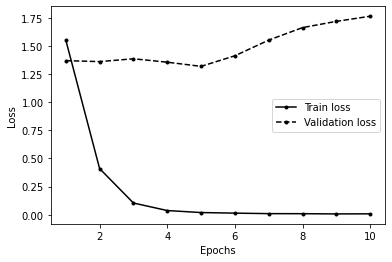

In [ ]:
#Learning curve
# pd.DataFrame(history5.history).plot(figsize=(5,5))#train and validation loss and accuracy across all epochs
# plt.title("Learning curve")
# plt.xlabel("Epochs")
# plt.ylabel("Loss and acuracy")
def eval_metric3(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    epoch = range(1, 10 + 1)

    plt.plot(epoch, metric, color="black",marker='.', label='Train ' + metric_name)
    plt.plot(epoch, val_metric, color="black",marker='.', linestyle='dashed',label='Validation ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

eval_metric3(history5,'loss')

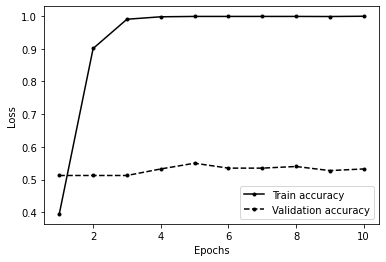

In [ ]:
eval_metric3(history5,'accuracy')

In [ ]:
model5.evaluate(X_test,Y_test) #52.21%
#comparable accuracy with and without batch normalization
#decrease in train and validation loss when Batch Normalization was used.

32/32 [==============================] - 0s 3ms/step - loss: 1.9397 - accuracy: 0.5210


[1.9397153854370117, 0.5210000276565552]

## **Learning rate scheduling**
#### **Piecewise constant scheduling** 

In [ ]:
#MLP with 2 layers, BN and early stopping

model6=keras.models.Sequential() 
model6.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,])) 
model6.add(keras.layers.BatchNormalization())
model6.add(keras.layers.Dense(100,activation="relu")) 
model6.add(keras.layers.BatchNormalization())
model6.add(keras.layers.Dense(5,activation="softmax"))

#Piecewise contant learning rate scheduler- lr is reduced after specified number of epochs
def piecewise_constant(epoch):
  if epoch<5:
    return 0.01
  elif epoch<8:
    return 0.005
  else:
    return 0.001


lr_scheduler=keras.callbacks.LearningRateScheduler(piecewise_constant )

model6.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])

checkpoint_callback6=keras.callbacks.ModelCheckpoint('model6.h5') #save at end of every epoch
history6=model6.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback6,early_stopping_cb,lr_scheduler],verbose=0)
model6.evaluate(X_test,Y_test) #50.50%

32/32 [==============================] - 0s 3ms/step - loss: 3.1784 - accuracy: 0.5050


[3.1784467697143555, 0.5049999952316284]

#### **Power scheduling**

In [ ]:
model7=keras.models.Sequential() 
model7.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,])) 
model7.add(keras.layers.BatchNormalization())
model7.add(keras.layers.Dense(100,activation="relu")) 
model7.add(keras.layers.BatchNormalization())
model7.add(keras.layers.Dense(5,activation="softmax"))

#power scheduling by setting decay hyperparameter
model7.compile(loss="categorical_crossentropy",optimizer= tf.keras.optimizers.Adam(lr=0.001,decay=1e-4),metrics=["accuracy"])  

checkpoint_callback7=keras.callbacks.ModelCheckpoint('model7.h5') #save at end of every epoch
history7=model7.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback7,early_stopping_cb],verbose=0)
model7.evaluate(X_test,Y_test) #51.00%

32/32 [==============================] - 0s 3ms/step - loss: 1.9001 - accuracy: 0.5100


[1.9001015424728394, 0.5099999904632568]

### **Exponential scheduling**

In [ ]:
model8=keras.models.Sequential() 
model8.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,])) 
model8.add(keras.layers.BatchNormalization())
model8.add(keras.layers.Dense(100,activation="relu")) 
model8.add(keras.layers.BatchNormalization())
model8.add(keras.layers.Dense(5,activation="softmax"))


model8.compile(loss="categorical_crossentropy",optimizer= 'Adam',metrics=["accuracy"])  

def exponential_decay(epoch):
  return 0.001*0.1**(epoch/5) #initial learning rate=0.001; decay rate=0.1; learning rate will drop after every 5 steps (decay steps)

lr_scheduler2=keras.callbacks.LearningRateScheduler(exponential_decay)
checkpoint_callback8=keras.callbacks.ModelCheckpoint('model8.h5') #save at end of every epoch
history8=model8.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback8,early_stopping_cb,lr_scheduler2],verbose=0)
model8.evaluate(X_test,Y_test) #51.00%

32/32 [==============================] - 0s 4ms/step - loss: 1.4607 - accuracy: 0.5100


[1.4607338905334473, 0.5099999904632568]

### **Performance scheduling**

In [ ]:
from keras.callbacks import ReduceLROnPlateau
model9=keras.models.Sequential() 
model9.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,])) 
model9.add(keras.layers.BatchNormalization())
model9.add(keras.layers.Dense(100,activation="relu")) 
model9.add(keras.layers.BatchNormalization())
model9.add(keras.layers.Dense(5,activation="softmax"))


model9.compile(loss="categorical_crossentropy",optimizer= 'Adam',metrics=["accuracy"])  

#Performance scheduling-lr reduced if no improvement seen for n epochs
lr_scheduler3 = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0001) #lr reduced by factor of 0.5 if train loss does not reduce for 5 epochs; lower bound of learning rate is 0.0001

checkpoint_callback9=keras.callbacks.ModelCheckpoint('model9.h5') #save at end of every epoch
history9=model9.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback9,early_stopping_cb,lr_scheduler3],verbose=0)
model9.evaluate(X_test,Y_test) #52.40%

32/32 [==============================] - 0s 3ms/step - loss: 1.9199 - accuracy: 0.5240


[1.9199318885803223, 0.5239999890327454]

### **1cycle scheduling**

In [ ]:
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa
model10=keras.models.Sequential() 
model10.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,])) 
model10.add(keras.layers.BatchNormalization())
model10.add(keras.layers.Dense(100,activation="relu")) 
model10.add(keras.layers.BatchNormalization())
model10.add(keras.layers.Dense(5,activation="softmax"))


#1cycle scheduling- lr first increases and then decreases
lr_scheduler4= tfa.optimizers.CyclicalLearningRate(initial_learning_rate=0.001, #specifying lower and upper bound of lr
    maximal_learning_rate=0.006,
    scale_fn=lambda x: 1/(2.**(x-1)), #to scale lr up and down
    step_size=2
)

model10.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(lr_scheduler4),metrics=["accuracy"])  

checkpoint_callback10=keras.callbacks.ModelCheckpoint('model10.h5') #save at end of every epoch
history10=model10.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback10,early_stopping_cb],verbose=0)
model10.evaluate(X_test,Y_test) #49.90%

32/32 [==============================] - 0s 7ms/step - loss: 2.0211 - accuracy: 0.4990


[2.0210859775543213, 0.49900001287460327]

### Best performance when performance lr scheduler was used.

## **Regularization**
#### **Dropout regularization**

#### **Trying different dropout rates**

In [ ]:
#MLP- 2 hidden layers, BN, performance scheduling, dropout, early stopping, performance scheduling
model11=keras.models.Sequential() 
model11.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,])) 
model11.add(keras.layers.Dropout(0.5)) #50% dropout rate
model11.add(keras.layers.BatchNormalization())
model11.add(keras.layers.Dense(100,activation="relu"))
model11.add(keras.layers.Dropout(0.5)) #50% dropout rate 
model11.add(keras.layers.BatchNormalization())
model11.add(keras.layers.Dense(5,activation="softmax"))


model11.compile(loss="categorical_crossentropy",optimizer= 'Adam',metrics=["accuracy"])  

#Performance scheduling-lr reduced if no improvement seen for n epochs
lr_scheduler3 = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0001) #lr reduced by factor of 0.5 if train loss does not reduce for 5 epochs; lower bound of learning rate is 0.0001

checkpoint_callback11=keras.callbacks.ModelCheckpoint('model11.h5') #save at end of every epoch
history11=model11.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback11,early_stopping_cb,lr_scheduler3],verbose=0)
model11.evaluate(X_test,Y_test) #54.20%

32/32 [==============================] - 0s 5ms/step - loss: 1.5695 - accuracy: 0.5420


[1.5694575309753418, 0.5419999957084656]

In [ ]:
for i in [0.2,0.3,0.5]:
  model11b=keras.models.Sequential() 
  model11b.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,])) 
  model11b.add(keras.layers.Dropout(i)) 
  model11b.add(keras.layers.BatchNormalization())
  model11b.add(keras.layers.Dense(100,activation="relu"))
  model11b.add(keras.layers.Dropout(i))  
  model11b.add(keras.layers.BatchNormalization())
  model11b.add(keras.layers.Dense(5,activation="softmax"))


  model11b.compile(loss="categorical_crossentropy",optimizer= 'Adam',metrics=["accuracy"])  

  #Performance scheduling-lr reduced if no improvement seen for n epochs
  lr_scheduler3 = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0001) #lr reduced by factor of 0.5 if train loss does not reduce for 5 epochs; lower bound of learning rate is 0.0001

  early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)
  checkpoint_callback11b=keras.callbacks.ModelCheckpoint('model11b.h5') #save at end of every epoch
  history11b=model11b.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback11b,early_stopping_cb,lr_scheduler3],verbose=0)
  print("Dropout rate:",i)
  model11b.evaluate(X_test,Y_test)
#Droput rate= 0.5 gave best lowest loss and highest accuracy 

Dropout rate: 0.2
32/32 [==============================] - 0s 4ms/step - loss: 1.3029 - accuracy: 0.5060
Dropout rate: 0.3
32/32 [==============================] - 0s 3ms/step - loss: 1.3467 - accuracy: 0.4990
Dropout rate: 0.5
32/32 [==============================] - 0s 4ms/step - loss: 1.2314 - accuracy: 0.5260


### **Alpha Dropout**

In [ ]:
model11c=keras.models.Sequential() 
model11c.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,])) 
model11c.add(keras.layers.AlphaDropout(0.5)) #50% dropout rate
model11c.add(keras.layers.BatchNormalization())
model11c.add(keras.layers.Dense(100,activation="relu"))
model11c.add(keras.layers.AlphaDropout(0.5)) #50% dropout rate 
model11c.add(keras.layers.BatchNormalization())
model11c.add(keras.layers.Dense(5,activation="softmax"))


model11c.compile(loss="categorical_crossentropy",optimizer= 'Adam',metrics=["accuracy"])  

checkpoint_callback11c=keras.callbacks.ModelCheckpoint('model11c.h5') #save at end of every epoch
history11c=model11c.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback11c,early_stopping_cb,lr_scheduler3],verbose=0)
model11c.evaluate(X_test,Y_test) #49.50%

32/32 [==============================] - 0s 3ms/step - loss: 1.3243 - accuracy: 0.4950


[1.3243217468261719, 0.4950000047683716]

#### **l1 regularization**

In [ ]:
model12=keras.models.Sequential() 
model12.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,],kernel_regularizer=keras.regularizers.l1(0.01))) 
model12.add(keras.layers.BatchNormalization())
model12.add(keras.layers.Dense(100,activation="relu",kernel_regularizer=keras.regularizers.l1(0.01)))
model12.add(keras.layers.BatchNormalization())
model12.add(keras.layers.Dense(5,activation="softmax",kernel_regularizer=keras.regularizers.l1(0.01)))


model12.compile(loss="categorical_crossentropy",optimizer= 'Adam',metrics=["accuracy"])  

#Performance scheduling-lr reduced if no improvement seen for n epochs
lr_scheduler3 = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0001) #lr reduced by factor of 0.5 if train loss does not reduce for 5 epochs; lower bound of learning rate is 0.0001

checkpoint_callback12=keras.callbacks.ModelCheckpoint('model12.h5') #save at end of every epoch
history12=model12.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback12,early_stopping_cb,lr_scheduler3],verbose=0)
model12.evaluate(X_test,Y_test) #48.40%

32/32 [==============================] - 0s 4ms/step - loss: 2.9052 - accuracy: 0.4840


[2.9051620960235596, 0.48399999737739563]

### **l2 regularization**

In [ ]:
model13=keras.models.Sequential() 
model13.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,],kernel_regularizer=keras.regularizers.l2(0.01))) 
model13.add(keras.layers.BatchNormalization())
model13.add(keras.layers.Dense(100,activation="relu",kernel_regularizer=keras.regularizers.l2(0.01)))
model13.add(keras.layers.BatchNormalization())
model13.add(keras.layers.Dense(5,activation="softmax",kernel_regularizer=keras.regularizers.l2(0.01)))


model13.compile(loss="categorical_crossentropy",optimizer= 'Adam',metrics=["accuracy"])  

#Performance scheduling-lr reduced if no improvement seen for n epochs
lr_scheduler3 = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0001) #lr reduced by factor of 0.5 if train loss does not reduce for 5 epochs; lower bound of learning rate is 0.0001

checkpoint_callback13=keras.callbacks.ModelCheckpoint('model13.h5') #save at end of every epoch
history13=model13.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback13,early_stopping_cb,lr_scheduler3],verbose=0)
model13.evaluate(X_test,Y_test) #51.30%

32/32 [==============================] - 0s 4ms/step - loss: 2.5276 - accuracy: 0.5130


[2.5276129245758057, 0.5130000114440918]

### **Max norm regularization**

In [ ]:
model14=keras.models.Sequential() 
model14.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,],kernel_constraint=keras.constraints.max_norm(1.))) 
model14.add(keras.layers.BatchNormalization())
model14.add(keras.layers.Dense(100,activation="relu",kernel_constraint=keras.constraints.max_norm(1.)))
model14.add(keras.layers.BatchNormalization())
model14.add(keras.layers.Dense(5,activation="softmax",kernel_constraint=keras.constraints.max_norm(1.)))


model14.compile(loss="categorical_crossentropy",optimizer= 'Adam',metrics=["accuracy"])  

#Performance scheduling-lr reduced if no improvement seen for n epochs
lr_scheduler3= ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0001) #lr reduced by factor of 0.5 if train loss does not reduce for 5 epochs; lower bound of learning rate is 0.0001

checkpoint_callback14=keras.callbacks.ModelCheckpoint('model14.h5') #save at end of every epoch
history14=model14.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback13,early_stopping_cb,lr_scheduler3],verbose=0)
model14.evaluate(X_test,Y_test) #44.70%

32/32 [==============================] - 0s 7ms/step - loss: 1.8314 - accuracy: 0.4470


[1.8314181566238403, 0.44699999690055847]

### **Elastic net regularizer (l1+l2)**

In [ ]:
model15=keras.models.Sequential() 
model15.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,],kernel_regularizer=keras.regularizers.l1_l2(0.01))) 
model15.add(keras.layers.BatchNormalization())
model15.add(keras.layers.Dense(100,activation="relu",kernel_regularizer=keras.regularizers.l1_l2(0.01)))
model15.add(keras.layers.BatchNormalization())
model15.add(keras.layers.Dense(5,activation="softmax",kernel_regularizer=keras.regularizers.l1_l2(0.01)))


model15.compile(loss="categorical_crossentropy",optimizer= 'Adam',metrics=["accuracy"])  

#Performance scheduling-lr reduced if no improvement seen for n epochs
lr_scheduler3 = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0001) #lr reduced by factor of 0.5 if train loss does not reduce for 5 epochs; lower bound of learning rate is 0.0001

checkpoint_callback15=keras.callbacks.ModelCheckpoint('model15.h5') #save at end of every epoch
history15=model15.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback15,early_stopping_cb,lr_scheduler3],verbose=0)
model15.evaluate(X_test,Y_test) #52.40%

32/32 [==============================] - 0s 5ms/step - loss: 2.7915 - accuracy: 0.5240


[2.79150390625, 0.5239999890327454]

### Best performance using dropout regularization.

## **Weight initializers**

In [ ]:
#Best model so far: MLP- 2 hidden layers, BN, performance scheduling, dropout with rate=0.5, early stopping, performance scheduling
for i in ["he_normal","he_uniform","lecun_normal","lecun_uniform","glorot_normal","glorot_uniform"]:
  model16=keras.models.Sequential() 
  model16.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,],kernel_initializer=i)) 
  model16.add(keras.layers.Dropout(0.5)) #50% dropout rate
  model16.add(keras.layers.BatchNormalization())
  model16.add(keras.layers.Dense(100,activation="relu",kernel_initializer=i))
  model16.add(keras.layers.Dropout(0.5)) #50% dropout rate 
  model16.add(keras.layers.BatchNormalization())
  model16.add(keras.layers.Dense(5,activation="softmax",kernel_initializer=i))

  model16.compile(loss="categorical_crossentropy",optimizer= 'Adam',metrics=["accuracy"])  

  checkpoint_callback16=keras.callbacks.ModelCheckpoint('model16.h5') #save at end of every epoch
  history16=model16.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback16,early_stopping_cb,lr_scheduler3],verbose=0)
  print("Kernel initializer:", i)
  model16.evaluate(X_test,Y_test) 

Kernel initializer: he_normal
32/32 [==============================] - 0s 3ms/step - loss: 1.2143 - accuracy: 0.5390
Kernel initializer: he_uniform
32/32 [==============================] - 0s 4ms/step - loss: 1.2220 - accuracy: 0.5360
Kernel initializer: lecun_normal
32/32 [==============================] - 0s 3ms/step - loss: 1.2589 - accuracy: 0.5370
Kernel initializer: lecun_uniform
32/32 [==============================] - 0s 3ms/step - loss: 1.5655 - accuracy: 0.5450
Kernel initializer: glorot_normal
32/32 [==============================] - 0s 4ms/step - loss: 1.2166 - accuracy: 0.5430
Kernel initializer: glorot_uniform
32/32 [==============================] - 0s 5ms/step - loss: 1.4457 - accuracy: 0.5270


#### Highest accuracy and lowest loss by lecun_uniform initialization.

## **Optimizers**

In [ ]:
#2 hidden layer MLP, BN, early stopping, dropout (rate=0.5), performance scheduling, relu activation function, lecun_uniform initialization
for i in ['SGD','rmsprop','adagrad','adam','nadam','adamax']:
  model17=keras.models.Sequential() 
  model17.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,],kernel_initializer="lecun_uniform")) 
  model17.add(keras.layers.Dropout(0.5)) #50% dropout rate
  model17.add(keras.layers.BatchNormalization())
  model17.add(keras.layers.Dense(100,activation="relu",kernel_initializer="lecun_uniform"))
  model17.add(keras.layers.Dropout(0.5)) #50% dropout rate 
  model17.add(keras.layers.BatchNormalization())
  model17.add(keras.layers.Dense(5,activation="softmax",kernel_initializer="lecun_uniform"))

  model17.compile(loss="categorical_crossentropy",optimizer=i,metrics=["accuracy"])  

  checkpoint_callback17=keras.callbacks.ModelCheckpoint('model17.h5') #save at end of every epoch
  history17=model17.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback17,early_stopping_cb,lr_scheduler3],verbose=0)
  print("Optimizer:", i)
  model17.evaluate(X_test,Y_test) 

Optimizer: SGD
32/32 [==============================] - 0s 3ms/step - loss: 1.2309 - accuracy: 0.5510
Optimizer: rmsprop
32/32 [==============================] - 0s 3ms/step - loss: 1.1962 - accuracy: 0.5410
Optimizer: adagrad
32/32 [==============================] - 0s 3ms/step - loss: 1.3801 - accuracy: 0.4760
Optimizer: adam
32/32 [==============================] - 0s 3ms/step - loss: 1.3261 - accuracy: 0.5330
Optimizer: nadam
32/32 [==============================] - 0s 13ms/step - loss: 1.2038 - accuracy: 0.5450
Optimizer: adamax
32/32 [==============================] - 0s 3ms/step - loss: 1.2338 - accuracy: 0.5430


#### Highest accuracy and lowest loss by adam optimizer.

### **Visualizing gradients and experimenting with Gradient Clipping**

In [ ]:
#without batch normalization
model17b=keras.models.Sequential() 
model17b.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,],kernel_initializer="lecun_uniform")) 
model17b.add(keras.layers.Dense(100,activation="relu",kernel_initializer="lecun_uniform")) 
model17b.add(keras.layers.Dense(5,activation="softmax",kernel_initializer="lecun_uniform"))

model17b.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])  

#Defining own callback function to save weights of each layer at end of epoch
from tensorflow.keras.callbacks import Callback
class model_weights(Callback):
    def __init__(self, model): #initializing model, weights of each layer and epochs
        super().__init__()
        self.model = model
        self.weights = []
        self.epochs = []
 
    def on_epoch_end(self, epoch, logs=None): #at end of each epoch, store weights
        self.epochs.append(epoch) 
        weight = {}
        for layer in model17b.layers:
            if not layer.weights:
                continue
            name = layer.weights[0].name.split("/")[0]
            weight[name] = layer.weights[0].numpy()
        self.weights.append(weight)
gradients_cb = model_weights(model17b) #callback function 
checkpoint_callback17b=keras.callbacks.ModelCheckpoint('model17b.h5')
model17b.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback17b,early_stopping_cb,lr_scheduler3,gradients_cb],verbose=0)

#### Gradients without BN

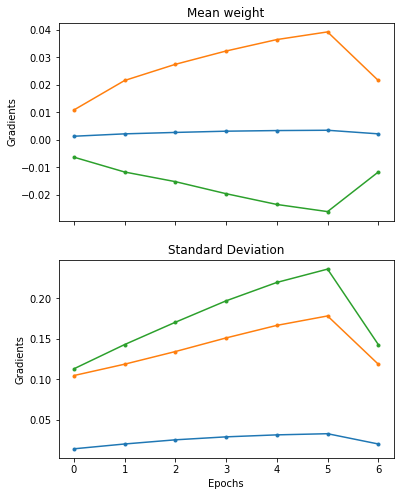

In [ ]:
#Plotting iterations/epochs vs mean and standard deviation of weights
import matplotlib.pyplot as plt
def plotweight(gradients_cb):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 8)) #2 plots
    ax[0].set_title("Mean weight") #title of first plot
    ax[1].set_xlabel("Epochs")
    ax[0].set_ylabel("Gradients")
    ax[1].set_ylabel("Gradients")
    for key in gradients_cb.weights[0]:
        ax[0].plot(gradients_cb.epochs, [w[key].mean() for w in gradients_cb.weights], label=key, marker='.') #plot epochs on x axis and mean of weights on y axis
    #ax[0].legend(loc="upperleft") #to distinguish between layers
    ax[1].set_title("Standard Deviation") #second plot on sd of weights
    for key in gradients_cb.weights[0]:
        ax[1].plot(gradients_cb.epochs, [w[key].std() for w in gradients_cb.weights], label=key, marker='.') #plot epochs on x axis and sd of weights on y axis
    #ax[1].legend(loc="upperleft")
    plt.show()
    
plotweight(gradients_cb)

#### Gradients with BN

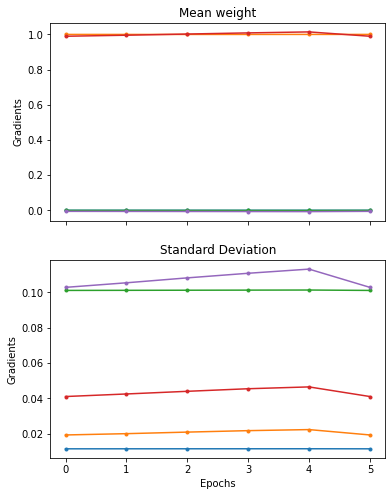

In [ ]:
#with BN
#using model17 (already defined and compiled)
class model_weights(Callback):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.weights = []
        self.epochs = []
 
    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch) 
        weight = {}
        for layer in model17.layers:
            if not layer.weights:
                continue
            name = layer.weights[0].name.split("/")[0]
            weight[name] = layer.weights[0].numpy()
        self.weights.append(weight)
gradients_cb2 = model_weights(model17)
#use gradients callback to get layer weights at end of epoch
model17.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback17,early_stopping_cb,lr_scheduler3,gradients_cb2],verbose=0)
#plot epochs vs mean/sd of weights
plotweight(gradients_cb2)

#### Gradients with Gradient Clipping

In [ ]:
#with gradient clipping
#define, compile model
model17c=keras.models.Sequential() 
model17c.add(keras.layers.Dense(100,activation="relu",input_shape=[8105,],kernel_initializer="lecun_uniform")) 
model17c.add(keras.layers.Dropout(0.5)) #50% dropout rate
model17c.add(keras.layers.Dense(100,activation="relu",kernel_initializer="lecun_uniform"))
model17c.add(keras.layers.Dropout(0.5)) #50% dropout rate 
model17c.add(keras.layers.Dense(5,activation="softmax",kernel_initializer="lecun_uniform"))

model17c.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(clipvalue=1.0),metrics=["accuracy"])  

checkpoint_callback17c=keras.callbacks.ModelCheckpoint('model17c.h5') #save at end of every epoch
history17c=model17c.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback17c,early_stopping_cb,lr_scheduler3],verbose=0)
model17c.evaluate(X_test,Y_test) #52.7%
#accuracy better with BN

32/32 [==============================] - 0s 3ms/step - loss: 1.2040 - accuracy: 0.5540


[1.2040464878082275, 0.5540000200271606]

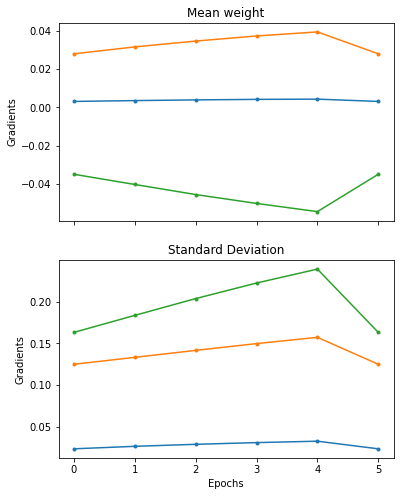

In [ ]:
class model_weights(Callback):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.weights = []
        self.epochs = []
 
    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch) 
        weight = {}
        for layer in model17c.layers:
            if not layer.weights:
                continue
            name = layer.weights[0].name.split("/")[0]
            weight[name] = layer.weights[0].numpy()
        self.weights.append(weight)
gradients_cb3 = model_weights(model17c)
#use gradients callback to get layer weights at end of epoch
model17c.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback17c,early_stopping_cb,lr_scheduler3,gradients_cb3],verbose=0)
#plot epochs vs mean/sd of weights
plotweight(gradients_cb3)

#### Gradients most stable for BN, Gradient Clippping shows slight improvement as compared to original model. 

### Number of Neurons in each hidden layer

In [ ]:
for i in [30, 50,100,200]:
  for j in [30,50,100,200]:
    model18=keras.models.Sequential() 
    model18.add(keras.layers.Dense(i,activation="relu",input_shape=[8105,],kernel_initializer="lecun_uniform")) 
    model18.add(keras.layers.Dropout(0.5)) #50% dropout rate
    model18.add(keras.layers.BatchNormalization())
    model18.add(keras.layers.Dense(i,activation="relu",kernel_initializer="lecun_uniform"))
    model18.add(keras.layers.Dropout(0.5)) #50% dropout rate 
    model18.add(keras.layers.BatchNormalization())
    model18.add(keras.layers.Dense(5,activation="softmax",kernel_initializer="lecun_uniform"))

    model18.compile(loss="categorical_crossentropy",optimizer='adam',metrics=["accuracy"])  

    checkpoint_callback18=keras.callbacks.ModelCheckpoint('model18.h5') 
    history18=model18.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[checkpoint_callback18,early_stopping_cb,lr_scheduler3],verbose=0)
    print("Number of neurons in layer 1:", i)
    print("Number of neurons in layer 2:", j)
    model18.evaluate(X_test,Y_test) 

Number of neurons in layer 1: 30
Number of neurons in layer 2: 30
32/32 [==============================] - 0s 2ms/step - loss: 1.2936 - accuracy: 0.5510
Number of neurons in layer 1: 30
Number of neurons in layer 2: 50
32/32 [==============================] - 0s 2ms/step - loss: 1.2817 - accuracy: 0.5450
Number of neurons in layer 1: 30
Number of neurons in layer 2: 100
32/32 [==============================] - 0s 2ms/step - loss: 1.2423 - accuracy: 0.5350
Number of neurons in layer 1: 30
Number of neurons in layer 2: 200
32/32 [==============================] - 0s 3ms/step - loss: 1.2918 - accuracy: 0.5410
Number of neurons in layer 1: 50
Number of neurons in layer 2: 30
32/32 [==============================] - 0s 2ms/step - loss: 1.2100 - accuracy: 0.5370
Number of neurons in layer 1: 50
Number of neurons in layer 2: 50
32/32 [==============================] - 0s 2ms/step - loss: 1.3703 - accuracy: 0.5340
Number of neurons in layer 1: 50
Number of neurons in layer 2: 100
32/32 [======

#### Best accuracy, lowest loss for 100 neurons in first hidden layer and 30 in second hidden layer.

#### Hyperparameters:
###### Learning rate: performance scheduling used to tune learning rate
###### Optimizer: experimented with ['SGD','rmsprop','adagrad','adam','nadam','adamax']
###### Activation function: experimented with ['tanh','elu','relu','sigmoid','softplus']
###### Number of hidden layers: experimented with [1,2,3,4]
###### Number of neurons in each hidden layer: experimented with combinations of [30,50,100,200]

### **Simple RNN**

In [ ]:
from keras.callbacks import ReduceLROnPlateau
embed_length = 32
model20 = keras.models.Sequential()
model20.add(keras.layers.Embedding(8105, embed_length, input_length=X_train.shape[1],)) #number of distinct words in the dataset; each word is shown according to give embedding size
model20.add(keras.layers.SimpleRNN(100,input_shape=[None,1]))#Simple RNN layer
model20.add(keras.layers.Dense(5,activation="softmax")) #output layer with 5 neurons for 5 classes

model20.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#Performance scheduling-lr reduced if no improvement seen for n epochs
lr_scheduler3 = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, min_lr=0.0001)
history20=model20.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3,callbacks=[lr_scheduler3])
model20.evaluate(X_test,Y_test) #49.5%, loss=0.4342

Epoch 1/3
113/113 [==============================] - 1036s 9s/step - loss: 0.4500 - accuracy: 0.4872 - val_loss: 0.4390 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 2/3
113/113 [==============================] - 879s 8s/step - loss: 0.4391 - accuracy: 0.4906 - val_loss: 0.4381 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 3/3
32/32 [==============================] - 15s 460ms/step - loss: 0.4342 - accuracy: 0.4950


[0.43417224287986755, 0.4950000047683716]

### **Deep RNN**

In [ ]:
model21 = keras.models.Sequential()
model21.add(keras.layers.Embedding(8105, embed_length, input_length=X_train.shape[1],))
#default tanh activation
model21.add(keras.layers.SimpleRNN(100, return_sequences=True)) #2 hidden layers,input_shape=[None, 1]
model21.add(keras.layers.SimpleRNN(30)) #return_sequences set as True for all recurrent layers except last one since we only want last output
model21.add(keras.layers.Dense(5, activation="softmax"))
model21.compile(loss="categorical_crossentropy", optimizer='Adam', metrics=["accuracy"])
history21 = model21.fit(X_train, Y_train, epochs=3,validation_data=(X_valid, Y_valid),callbacks=[lr_scheduler3])
model21.evaluate(X_test,Y_test)

Epoch 1/3
113/113 [==============================] - 1658s 15s/step - loss: 1.3841 - accuracy: 0.4875 - val_loss: 1.3333 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 2/3
113/113 [==============================] - 1685s 15s/step - loss: 1.3755 - accuracy: 0.4906 - val_loss: 1.3330 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 3/3
32/32 [==============================] - 27s 837ms/step - loss: 1.3696 - accuracy: 0.4950


[1.3696328401565552, 0.4950000047683716]

## **RNN with Layer Normalization**

In [ ]:
from tensorflow.keras.layers import LayerNormalization

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]
embed_length=32
model21b = keras.models.Sequential()
model21b.add(keras.layers.Embedding(8105, embed_length, input_length=X_train.shape[1],))
model21b.add(keras.layers.RNN(LNSimpleRNNCell(100), return_sequences=True,input_shape=[None,1])) #input_shape=[None, 1]
model21b.add(keras.layers.RNN(LNSimpleRNNCell(30)))
model21b.add(keras.layers.Dense(5,activation="softmax"))

model21b.compile(loss="categorical_crossentropy", optimizer="adam",metrics=['accuracy'])
history21b = model21b.fit(X_train, Y_train, epochs=3,validation_data=(X_valid, Y_valid),callbacks=[lr_scheduler3])
model21b.evaluate(X_test,Y_test) 

Epoch 1/3
113/113 [==============================] - 283s 2s/step - loss: 0.4640 - accuracy: 0.4925 - val_loss: 0.4361 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 2/3
113/113 [==============================] - 272s 2s/step - loss: 0.4362 - accuracy: 0.4953 - val_loss: 0.4381 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 3/3
32/32 [==============================] - 29s 899ms/step - loss: 0.4355 - accuracy: 0.4930


[0.4355091452598572, 0.49300000071525574]

## **LSTM**

In [ ]:
#1 hidden layer
model22 = keras.models.Sequential()
model22.add(keras.layers.Embedding(8105, embed_length, input_length=X_train.shape[1],)) #number of distinct words in the dataset; each word is shown according to give embedding size
model22.add(keras.layers.LSTM(100)) #LSTM layer
#100 neurons, default tanh activation function
model22.add(keras.layers.Dense(5, activation='softmax')) #output layer

model22.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model22.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3,callbacks=[lr_scheduler3])
model22.evaluate(X_test,Y_test) #49.5%, loss=0.4354

Epoch 1/3
113/113 [==============================] - 1361s 11s/step - loss: 0.4601 - accuracy: 0.4878 - val_loss: 0.4356 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 2/3
113/113 [==============================] - 1278s 11s/step - loss: 0.4383 - accuracy: 0.4906 - val_loss: 0.4337 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 3/3
32/32 [==============================] - 39s 1s/step - loss: 0.4354 - accuracy: 0.4950


[0.43535077571868896, 0.4950000047683716]

In [ ]:
#2 hidden layers
model22b = keras.models.Sequential()
model22b.add(keras.layers.Embedding(8105, embed_length, input_length=X_train.shape[1],)) #number of distinct words in the dataset; each word is shown according to give embedding size
model22b.add(keras.layers.LSTM(100, return_sequences=True, input_shape=[None,1])) #LSTM layer 1
#100 neurons, default tanh activation function
model22b.add(keras.layers.LSTM(30)) #LSTM layer 2
#30 neurons, default tanh activation function
model22b.add(keras.layers.Dense(5, activation='softmax')) #output layer

model22b.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model22b.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3,callbacks=[lr_scheduler3])
model22b.evaluate(X_test,Y_test) #49.5%, loss=0.4383

Epoch 1/3
113/113 [==============================] - 2208s 19s/step - loss: 0.4557 - accuracy: 0.4906 - val_loss: 0.4359 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 2/3
113/113 [==============================] - 2116s 19s/step - loss: 0.4371 - accuracy: 0.4906 - val_loss: 0.4342 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 3/3
32/32 [==============================] - 58s 2s/step - loss: 0.4383 - accuracy: 0.4950


[0.43831756711006165, 0.4950000047683716]

## **LSTM with Dropout**

In [ ]:
model23 = keras.models.Sequential()
model23.add(keras.layers.Embedding(8105, embed_length, input_length=X_train.shape[1],)) #number of distinct words in the dataset; each word is shown according to give embedding size
model23.add(keras.layers.LSTM(100,return_sequences=True, input_shape=[None,1])) #LSTM layer 1
model23.add(keras.layers.Dropout(0.5))
#100 neurons, default tanh activation function
model23.add(keras.layers.LSTM(30)) #LSTM layer 2
model23.add(keras.layers.Dropout(0.5))
#30 neurons, default tanh ac tivation function
model23.add(keras.layers.Dense(5, activation='softmax')) #output layer

model23.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history23=model23.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=10,callbacks=[lr_scheduler3])
model23.evaluate(X_test,Y_test)

Epoch 1/10
113/113 [==============================] - 59s 501ms/step - loss: 0.4869 - accuracy: 0.4500 - val_loss: 0.4352 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 2/10
113/113 [==============================] - 56s 494ms/step - loss: 0.4576 - accuracy: 0.4869 - val_loss: 0.4355 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 3/10
113/113 [==============================] - 56s 495ms/step - loss: 0.4521 - accuracy: 0.4872 - val_loss: 0.4337 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 4/10
113/113 [==============================] - 56s 494ms/step - loss: 0.4513 - accuracy: 0.4894 - val_loss: 0.4344 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 5/10
113/113 [==============================] - 56s 494ms/step - loss: 0.4495 - accuracy: 0.4894 - val_loss: 0.4341 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 6/10
113/113 [==============================] - 56s 494ms/step - loss: 0.4493 - accuracy: 0.4906 - val_loss: 0.4345 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 7/10
113/113 [==============================] 

[0.4344644248485565, 0.4950000047683716]

## **GRU**

In [ ]:
#1 hidden layer
model24 = keras.models.Sequential()
model24.add(keras.layers.Embedding(8105, embed_length, input_length=X_train.shape[1],)) #number of distinct words in the dataset; each word is shown according to give embedding size
model24.add(keras.layers.GRU(100,input_shape=[None,1])) #GRU layer
#100 neurons, default tanh activation function
model24.add(keras.layers.Dense(5, activation='softmax')) #output layer

model24.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model24.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3,callbacks=[lr_scheduler3])
model24.evaluate(X_test,Y_test)

Epoch 1/3
113/113 [==============================] - 32s 273ms/step - loss: 0.4672 - accuracy: 0.4842 - val_loss: 0.4347 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 2/3
113/113 [==============================] - 32s 285ms/step - loss: 0.4378 - accuracy: 0.4906 - val_loss: 0.4360 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 3/3
32/32 [==============================] - 3s 102ms/step - loss: 0.4363 - accuracy: 0.4950


[0.43626055121421814, 0.4950000047683716]

In [ ]:
#2 hidden layers
model24b = keras.models.Sequential()
model24b.add(keras.layers.Embedding(8105, embed_length, input_length=X_train.shape[1],)) #number of distinct words in the dataset; each word is shown according to give embedding size
model24b.add(keras.layers.GRU(100,return_sequences=True,input_shape=[None,1])) #GRU layer 1
#100 neurons, default tanh activation function
model24b.add(keras.layers.GRU(30)) #GRU layer 2
model24b.add(keras.layers.Dense(5, activation='softmax')) #output layer

model24b.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model24b.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3,callbacks=[lr_scheduler3])
model24b.evaluate(X_test,Y_test)

Epoch 1/3
113/113 [==============================] - 56s 472ms/step - loss: 0.4643 - accuracy: 0.4883 - val_loss: 0.4344 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 2/3
113/113 [==============================] - 53s 466ms/step - loss: 0.4374 - accuracy: 0.4906 - val_loss: 0.4337 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 3/3
32/32 [==============================] - 6s 187ms/step - loss: 0.4353 - accuracy: 0.4950


[0.43527865409851074, 0.4950000047683716]

## **GRU with Dropout**

In [ ]:
model25 = keras.models.Sequential()
model25.add(keras.layers.Embedding(8105, embed_length, input_length=X_train.shape[1],)) #number of distinct words in the dataset; each word is shown according to give embedding size
model25.add(keras.layers.GRU(100,return_sequences=True,input_shape=[None,1])) #GRU layer 1
model25.add(keras.layers.Dropout(0.5))
#100 neurons, default tanh activation function
model25.add(keras.layers.GRU(30)) #GRU layer 2
model25.add(keras.layers.Dropout(0.5))
model25.add(keras.layers.Dense(5, activation='softmax')) #output layer

model25.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model25.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=3,callbacks=[lr_scheduler3])
model25.evaluate(X_test,Y_test)

Epoch 1/3
113/113 [==============================] - 57s 475ms/step - loss: 0.4924 - accuracy: 0.4736 - val_loss: 0.4341 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 2/3
113/113 [==============================] - 53s 472ms/step - loss: 0.4556 - accuracy: 0.4861 - val_loss: 0.4340 - val_accuracy: 0.4950 - lr: 0.0010
Epoch 3/3
32/32 [==============================] - 6s 183ms/step - loss: 0.4359 - accuracy: 0.4950


[0.43587931990623474, 0.4950000047683716]

## **Stacked Bidirectional RNN**

In [ ]:
from tensorflow.keras.layers import Bidirectional
embed_length = 32
model26=keras.models.Sequential()
model26.add(keras.layers.Embedding(8105,embed_length,input_length=X_train.shape[1],))
model26.add(Bidirectional(keras.layers.LSTM(100,return_sequences=True,input_shape=[None,1])))
model26.add(Bidirectional(keras.layers.LSTM(30)))
model26.add(keras.layers.Dense(64,activation="tanh"))
model26.add(keras.layers.Dense(5,activation="softmax"))

model26.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
history26=model26.fit(X_train,Y_train,epochs=3,validation_data=(X_valid,Y_valid),callbacks=[lr_scheduler3])
model26.evaluate(X_test,Y_test)

Epoch 1/3
113/113 [==============================] - 130s 1s/step - loss: 1.5086 - accuracy: 0.4653 - val_loss: 1.4182 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 2/3
113/113 [==============================] - 124s 1s/step - loss: 1.4058 - accuracy: 0.4906 - val_loss: 1.3603 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 3/3
32/32 [==============================] - 13s 391ms/step - loss: 1.3662 - accuracy: 0.4950


[1.3661597967147827, 0.4950000047683716]

## **Stacked Bidirectional LSTM with recurrent dropout**
#### Recurrent dropout for dropping connections between recurrent units (when unfolded through time)

In [ ]:
model27=keras.models.Sequential()
model27.add(keras.layers.Embedding(8105,embed_length,input_length=X_train.shape[1],))
model27.add(keras.layers.Bidirectional(keras.layers.LSTM(100,recurrent_dropout=0.5,return_sequences=True,input_shape=[None,1])))
model27.add(keras.layers.Bidirectional(keras.layers.LSTM(30,recurrent_dropout=0.5)))
model27.add(keras.layers.Dense(64,activation="relu"))
model27.add(keras.layers.Dense(5,activation="softmax"))

model27.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
history27=model27.fit(X_train,Y_train,epochs=3,validation_data=(X_valid,Y_valid),callbacks=[lr_scheduler3])
model27.evaluate(X_test,Y_test)

Epoch 1/3
113/113 [==============================] - 271s 2s/step - loss: 0.4575 - accuracy: 0.4892 - val_loss: 0.4355 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 2/3
113/113 [==============================] - 263s 2s/step - loss: 0.4356 - accuracy: 0.4953 - val_loss: 0.4355 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 3/3
32/32 [==============================] - 26s 819ms/step - loss: 0.4357 - accuracy: 0.4930


[0.43572646379470825, 0.49300000071525574]

## Adding more dense layers to stacked bidirectionsal LSTM

In [ ]:
model27b=keras.models.Sequential()
model27b.add(keras.layers.Embedding(8105,embed_length,input_length=X_train.shape[1],))
model27b.add(keras.layers.Bidirectional(keras.layers.LSTM(100,return_sequences=True,input_shape=[None,1])))
model27b.add(keras.layers.Bidirectional(keras.layers.LSTM(30)))
model27b.add(keras.layers.Dense(225,activation='relu'))
model27b.add(keras.layers.Dropout(0.3))
model27b.add(keras.layers.Dense(150,activation='relu'))
model27b.add(keras.layers.Dropout(0.2))
model27b.add(keras.layers.Dense(95,activation='relu'))
model27b.add(keras.layers.Dropout(0.2))
model27b.add(keras.layers.Dense(64,activation='relu'))
model27b.add(keras.layers.Dropout(0.1))
model27b.add(keras.layers.Dense(34,activation='relu'))
model27b.add(keras.layers.Dropout(0.1))
model27b.add(keras.layers.Dense(32,activation='relu'))
model27b.add(keras.layers.Dense(5, activation='softmax'))


model27b.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
history27b=model27b.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[lr_scheduler3])
model27b.evaluate(X_test,Y_test)

Epoch 1/10
113/113 [==============================] - 112s 942ms/step - loss: 1.4149 - accuracy: 0.4814 - val_loss: 1.3495 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 2/10
113/113 [==============================] - 112s 990ms/step - loss: 1.3865 - accuracy: 0.4906 - val_loss: 1.3328 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 3/10
113/113 [==============================] - 114s 1s/step - loss: 1.3774 - accuracy: 0.4906 - val_loss: 1.3476 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 4/10
113/113 [==============================] - 108s 959ms/step - loss: 1.3773 - accuracy: 0.4906 - val_loss: 1.3277 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 5/10
113/113 [==============================] - 106s 939ms/step - loss: 1.3750 - accuracy: 0.4906 - val_loss: 1.3383 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 6/10
113/113 [==============================] - 106s 937ms/step - loss: 1.3745 - accuracy: 0.4906 - val_loss: 1.3331 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 7/10
113/113 [=============================

[1.3578294515609741, 0.4950000047683716]

## **1d Convolution network to learn patterns in the sequences**

In [ ]:
model28=keras.models.Sequential()
model28.add(keras.layers.Embedding(8105,embed_length,input_length=X_train.shape[1],))
model28.add(keras.layers.Conv1D(filters=32, kernel_size=3,padding='same')) #convolution layer with 32 filters of size 3x3, same padding
model28.add(keras.layers.MaxPooling1D(2))#max pooling layer, pool size=2
model28.add(keras.layers.Conv1D(32, 3,padding="same"))
model28.add(keras.layers.GlobalMaxPooling1D())
model28.add(keras.layers.Dense(5,activation='softmax'))


model28.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
history28=model28.fit(X_train,Y_train,epochs=3,validation_data=(X_valid,Y_valid),callbacks=[lr_scheduler3])
model28.evaluate(X_test,Y_test)

Epoch 1/3
113/113 [==============================] - 10s 20ms/step - loss: 1.3992 - accuracy: 0.4875 - val_loss: 1.3359 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 2/3
113/113 [==============================] - 2s 17ms/step - loss: 1.3709 - accuracy: 0.4906 - val_loss: 1.3291 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 3/3
32/32 [==============================] - 0s 9ms/step - loss: 1.3576 - accuracy: 0.4950


[1.3576143980026245, 0.4950000047683716]

## **Hybrid model**
### **1d Convolution network with LSTM**

In [ ]:
model28b=keras.models.Sequential()
model28b.add(keras.layers.Embedding(8105,embed_length,input_length=X_train.shape[1],))
model28b.add(keras.layers.Conv1D(filters=32,kernel_size=3,padding="same",activation="relu"))#convolution layer with 32 filters of size 3x3, same padding
model28b.add(keras.layers.MaxPooling1D(2))#max pooling layer, pool size=2
model28b.add(keras.layers.Conv1D(filters=32,kernel_size=3,padding="same",activation="relu"))
model28b.add(keras.layers.MaxPooling1D(2))
model28b.add(keras.layers.Bidirectional(keras.layers.LSTM(100,return_sequences=True)))
model28b.add(keras.layers.Bidirectional(keras.layers.LSTM(30)))
model28b.add(keras.layers.Dense(225,activation='relu')) #dense layers
model28b.add(keras.layers.Dropout(0.3))
model28b.add(keras.layers.Dense(150,activation='relu'))
model28b.add(keras.layers.Dropout(0.2))
model28b.add(keras.layers.Dense(95,activation='relu'))
model28b.add(keras.layers.Dropout(0.2))
model28b.add(keras.layers.Dense(64,activation='relu'))
model28b.add(keras.layers.Dropout(0.1))
model28b.add(keras.layers.Dense(34,activation='relu'))
model28b.add(keras.layers.Dropout(0.1))
model28b.add(keras.layers.Dense(32,activation='relu'))
model28b.add(keras.layers.Dense(5,activation="softmax"))

model28b.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
history28b=model28b.fit(X_train,Y_train,epochs=10,validation_data=(X_valid,Y_valid),callbacks=[lr_scheduler3])
model28b.evaluate(X_test,Y_test)


Epoch 1/10
113/113 [==============================] - 36s 269ms/step - loss: 1.4172 - accuracy: 0.4886 - val_loss: 1.3333 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 2/10
113/113 [==============================] - 34s 303ms/step - loss: 1.3746 - accuracy: 0.4906 - val_loss: 1.3276 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 3/10
113/113 [==============================] - 29s 258ms/step - loss: 1.3826 - accuracy: 0.4906 - val_loss: 1.3373 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 4/10
113/113 [==============================] - 29s 253ms/step - loss: 1.3760 - accuracy: 0.4906 - val_loss: 1.3356 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 5/10
113/113 [==============================] - 29s 253ms/step - loss: 1.3738 - accuracy: 0.4906 - val_loss: 1.3317 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 6/10
113/113 [==============================] - 31s 273ms/step - loss: 1.3726 - accuracy: 0.4906 - val_loss: 1.3324 - val_accuracy: 0.5125 - lr: 0.0010
Epoch 7/10
113/113 [==============================] 

[1.3594410419464111, 0.4950000047683716]

## **Lowest loss so far achieved with LSTM (with dropout)**

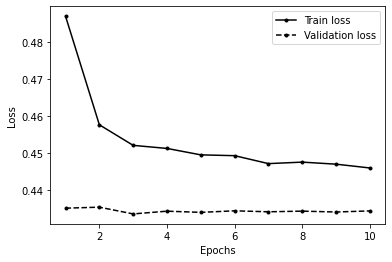

In [ ]:
import matplotlib.pyplot as plt
def eval_metric4(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    epoch = range(1, 10 + 1)

    plt.plot(epoch, metric, color="black",marker='.', label='Train ' + metric_name)
    plt.plot(epoch, val_metric, color="black",marker='.', linestyle='dashed',label='Validation ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
eval_metric4(history23,'loss')

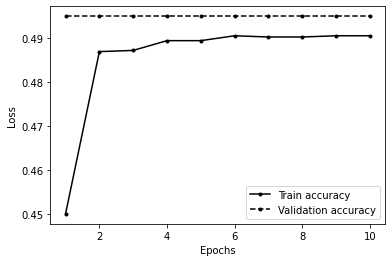

In [ ]:
eval_metric4(history23,'accuracy')

## **Comparing performance with machine learning model (Random forest)**

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
rf.fit(X_train, Y_train)
y_pred_rf = rf.predict(X_test)
rf_accuracy=round(accuracy_score(Y_test,y_pred_rf),4)*100
print("Accuracy for Random Forest: {}%".format(rf_accuracy))

Accuracy for Random Forest: 32.1%


### Neural networks (even a simple MLP) gave higher accuracy than a statistical ML model for my problem statement. 